# Property Prediction and Structural Relaxation using Orb Interatomic Potential

This notebook demonstrates how to use the Orb universal interatomic potential for predicting properties and performing structural relaxation of materials. We will cover installation, setup, and practical examples using the Atomic Simulation Environment (ASE).

Before we begin, ensure that you are running this notebook in an environment that supports GPU acceleration for optimal performance. You can enable GPU in Google Colab by navigating to `Runtime` > `Change runtime type` and selecting one of the `GPU`s as the hardware accelerator.


## Install Required Packages
We will install the necessary Python packages, including `orb-models` for the Orb interatomic potential and `ase` for the Atomic Simulation Environment.


In [ ]:
!pip install ase
!pip install orb-models==0.4.2
!pip install "pynanoflann@git+https://github.com/dwastberg/pynanoflann#egg=af434039ae14bedcbb838a7808924d6689274168",

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.0 MB/s eta 0:00:00
DEPRECATION: git+https://github.com/dwastberg/pynanoflann#egg=af434039ae14bedcbb838a7808924d6689274168, contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Cloning https://github.com/dwastberg/pynanoflann to /tmp/pip-install-ivvhsan5/pynanoflann_f56a03c8ffad45bb9865c634da41ac7f
  Running command git clone --filter=blob:none --quiet https://github.com/dwastberg/pynanoflann /tmp/pip-install-ivvhsan5/pynanoflan

## Import Libraries
Import the necessary libraries for this notebook.

In [ ]:
import os
import random
import requests
import warnings
from tqdm import tqdm

import torch
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.build import bulk
from ase.optimize import FIRE
from ase.io import write, read
from ase.visualize import view

from orb_models.forcefield import pretrained
from orb_models.forcefield.calculator import ORBCalculator

warnings.simplefilter("ignore") # To suppress warnings for clearer output

/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


## Load the Orb Model
We will load the pre-trained Orb model. The `orb_v2` model is trained on the MPTraj and Alexandria datasets.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set the device to GPU if available, otherwise use CPU

orb_model = pretrained.orb_v2(device=device) # Load the pre-trained Orb model

## Create an Atomic Structure

For this demonstration, we will create a simple face-centered cubic (FCC) copper crystal using ASE's `bulk` function.

In [ ]:
atoms = bulk(
    name='Cu',
    crystalstructure='fcc',
    a=3.58,
    cubic=True
  )

In [ ]:
view(atoms, viewer='x3d') # Visualize the initial structure

## Set Up the Orb Calculator
We will set up the Orb calculator, which allows ASE to interface with the Orb model for property calculations.

In [ ]:
calc = ORBCalculator(orb_model, device=device)

atoms.calc = calc # Attach the calculator to the atoms object

## Property Prediction

With the calculator attached, we can predict various properties of the system, such as the potential energy, atomic forces, and stresses.

In [ ]:
initial_energy = atoms.get_potential_energy()
print(f"Initial Potential Energy: {initial_energy:.4f} eV")
print()

forces = atoms.get_forces()
print("Forces on atoms (in eV/Å):")
print(forces)
print()

stress = atoms.get_stress(voigt=False)  # voigt=False returns the full 3x3 stress tensor
print("Stress tensor (in eV/Å³):")
print(stress)

Initial Potential Energy: -16.3509 eV

Forces on atoms (in eV/Å):
[[ 2.2136151e-06 -2.0291488e-06 -1.2359365e-06]
 [ 7.3787101e-07 -5.9029855e-07 -3.6893692e-07]
 [-2.3242976e-06  2.1398278e-06  1.5679771e-06]
 [-6.2719215e-07  4.4272227e-07  1.8445855e-08]]

Stress tensor (in eV/Å³):
[[-3.4125350e-02 -1.1067605e-06 -1.5991682e-06]
 [-1.1067605e-06 -3.3970900e-02 -2.8088107e-07]
 [-1.5991682e-06 -2.8088107e-07 -3.3965088e-02]]


## Structural Relaxation
To find the equilibrium structure, we can perform geometry optimization (structural relaxation) using ASE's optimization algorithms. Here, we use the FIRE optimizer. For additional information check https://wiki.fysik.dtu.dk/ase/ase/optimize.html

In [ ]:
atoms.rattle(0.5) # Rattle the atoms to get them out of the minimum energy configuration
print(f"Rattled Energy: {atoms.get_potential_energy():.4f} eV \n")


optimizer = FIRE(atoms)
optimizer.run(fmax=0.001) # Run the optimization until the forces are below 0.01 eV/Å
print()

final_energy = atoms.get_potential_energy()
print(f"Final Potential Energy after Optimization: {final_energy:.4f} eV \n")

forces = atoms.get_forces()
print("Final Forces on atoms after Optimization (in eV/Å):")
print(forces)
print()

final_stress = atoms.get_stress(voigt=False)
print("Stress tensor after optimization (in eV/Å³): \n")
print(final_stress)

Rattled Energy: -11.9750 eV 

      Step     Time          Energy          fmax
FIRE:    0 21:21:48      -11.975014       12.992562
FIRE:    1 21:21:48      -13.987800        4.939954
FIRE:    2 21:21:48      -14.987174        3.760055
FIRE:    3 21:21:48      -15.618917        2.827189
FIRE:    4 21:21:48      -15.966377        1.665329
FIRE:    5 21:21:48      -15.978931        2.457577
FIRE:    6 21:21:48      -16.003304        2.345386
FIRE:    7 21:21:48      -16.047855        2.133311
FIRE:    8 21:21:48      -16.105747        1.843814
FIRE:    9 21:21:48      -16.169012        1.505903
FIRE:   10 21:21:48      -16.228779        1.148404
FIRE:   11 21:21:48      -16.275459        0.782379
FIRE:   12 21:21:48      -16.296490        0.422267
FIRE:   13 21:21:49      -16.312431        0.411198
FIRE:   14 21:21:49      -16.306488        0.483295
FIRE:   15 21:21:49      -16.307190        0.476159
FIRE:   16 21:21:49      -16.308577        0.462064
FIRE:   17 21:21:49      -16.310617 

## Comparing Orb Predictions with DFT Results
Here, we download a molecular dynamics dataset from SevenNet's AIMD evaluation repository and evaluate the accuracy of Orb predictions against DFT calculations.

In [ ]:
url = 'https://raw.githubusercontent.com/MDIL-SNU/sevennet_tutorial/main/data/evaluation/test_md.extxyz'

filename = os.path.basename(url)
response = requests.get(url)

if response.status_code == 200:
    with open(filename, 'wb') as file:
        file.write(response.content)
    print(f"File '{filename}' downloaded successfully.")
else:
    print(f"Failed to download file. HTTP Status Code: {response.status_code}")

try:
    traj = read(filename, index=':')
    print(f"File '{filename}' read successfully with ASE.")
except Exception as e:
    print(f"Error reading file '{filename}' with ASE: {e}")

File 'test_md.extxyz' downloaded successfully.
File 'test_md.extxyz' read successfully with ASE.


In [ ]:
dft_energy, dft_forces = [], []
base_energy, base_forces= [], []

for atoms in tqdm(traj):
  atoms.calc = calc
  base_energy.append(atoms.get_potential_energy() / len(atoms))
  base_forces.append(atoms.get_forces())

  dft_energy.append(atoms.info['DFT_energy'] / len(atoms))
  dft_forces.append(atoms.arrays['DFT_forces'])

base_energy = np.array(base_energy)
dft_energy = np.array(dft_energy)

# flatten forces and stress for parity plot
base_forces = np.concatenate([f.reshape(-1,) for f in base_forces])
dft_forces = np.concatenate([f.reshape(-1,) for f in dft_forces])

100%|██████████| 100/100 [00:08<00:00, 11.49it/s]


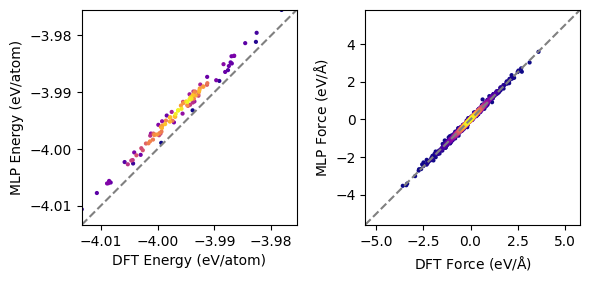

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

UNIT = {
    "Energy": "eV/atom",
    "Force": r"eV/$\rm{\AA}$",

}

def density_colored_scatter_plot(dft_energy, nnp_energy, dft_force, nnp_force):
    """
    Generates scatter plots comparing DFT vs. MLP predictions for energy and force,
    with color density based on Gaussian KDE.

    Parameters:
        dft_energy (array-like): DFT computed energy values.
        nnp_energy (array-like): MLP predicted energy values.
        dft_force (array-like): DFT computed force values.
        nnp_force (array-like): MLP predicted force values.
    """

    data_pairs = [
        ("Energy", dft_energy, nnp_energy),
        ("Force", dft_force, nnp_force)
    ]

    fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    for ax, (mode, x, y) in zip(axes, data_pairs):
        if len(x) > 1000:
            idx = np.random.choice(len(x), 1000, replace=False) # Downsample if needed
            x_sample, y_sample = np.array(x)[idx], np.array(y)[idx]
        else:
            x_sample, y_sample = np.array(x), np.array(y)


        xy = np.vstack([x_sample, y_sample])
        density = gaussian_kde(xy)(xy) # Compute density
        sorted_idx = density.argsort()
        x_sorted, y_sorted, density_sorted = x_sample[sorted_idx], y_sample[sorted_idx], density[sorted_idx] # Sort points by density for better visualization

        sc = ax.scatter(x_sorted, y_sorted, c=density_sorted, s=4, cmap='plasma')

        min_val, max_val = min(x.min(), y.min()), max(x.max(), y.max())
        ax.plot([min_val, max_val], [min_val, max_val], color='grey', linestyle='dashed')

        ax.set_xlabel(f'DFT {mode} ({UNIT[mode]})')
        ax.set_ylabel(f'MLP {mode} ({UNIT[mode]})')
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)
        ax.set_aspect('equal')

    plt.tight_layout()
    plt.show()

density_colored_scatter_plot(dft_energy, base_energy, dft_forces, base_forces)
